In [2]:
from IPython.html.services.config import ConfigManager
from IPython.paths import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
              'scroll': True,
})


{u'scroll': True,
 u'scroll:': True,
 u'start_slideshow_at': 'selected',
 u'theme': 'sky',
 u'transition': 'zoom'}

# Lecture 4: Barnes-Hut and FMM

## Previous lecture
-  FFT and pFFT.
- BEM++ demo

## Todays lecture
- The basic idea of Barnes-Hut method

## Core problem

The discretization of the integral equation leads to **dense matrices**.  

The main question is how to compute the **matrix-by-vector product**, 

i.e. the summation of the form:

$$\sum_{j=1}^M A_{ij} q_j = V_i, \quad i = 1, \ldots, N.$$

The matrix $A$ is **dense**, i.e. its element can not be omitted. The complexity is $\mathcal{O}(N^2)$.  

Can we make it faster?

## Model dense-matrix-by-vector product

The **N-Body problem** is the problem of computing interactions between $N$ point bodies.

The simplest model problem reads:

$$V_i = \sum_{j} \frac{q_j}{\Vert r_i - r_j \Vert}$$

This summation appears in:

- Modelling of large systems of charges
- Astronomy (where instead of $q_j$ we have **masses**, i.e. start..)

It is called <font color='red'> the N-body problem </font>.  

There is no problem with memory, since you only have two cycles.

In [2]:
import numpy as np
import math
from numba import jit
N = 10000
x = np.random.randn(N, 2);
y = np.random.randn(N, 2);
charges = np.ones(N)
res = np.zeros(N)


@jit
def compute_nbody_direct(N, x, y, charges, res):
    for i in xrange(N):
        res[i] = 0.0
        for j in xrange(N):
            dist = (x[i, 0] - y[i, 0]) ** 2 + (x[i, 1] - y[i, 1]) ** 2
            dist = math.sqrt(dist)
            res[i] += charges[j] / dist
                    

In [3]:
%timeit compute_nbody_direct(N, x, y, charges, res)


1 loop, best of 3: 459 ms per loop


## Question
What is the typical size of particle system?

## Millenium run
One of the most famous N-body computations is the [Millenium run](http://en.wikipedia.org/wiki/Millennium_Run)

- More than 10 billions particles ($2000^3$)
- $>$ **1 month** of computations, **25 Terabytes** of storage
- Each "particle" represents approximately a billion solar masses of dark matter
- Study, how the matter is distributed through the Universy (cosmology)

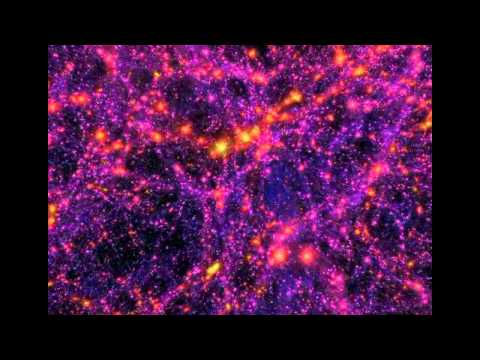

In [6]:
from IPython.display import YouTubeVideo

YouTubeVideo('UC5pDPY5Nz4')

## Smoothed particle hydrodynamics
The particle systems can be used to model a lot of things. 

For nice examples, see the website of [Ron Fedkiw](http://physbam.stanford.edu/~fedkiw/)

One of the application areas is so-called **smoothed particle hydrodynamics**, where the fluid is modelled by a system of interacting particles.

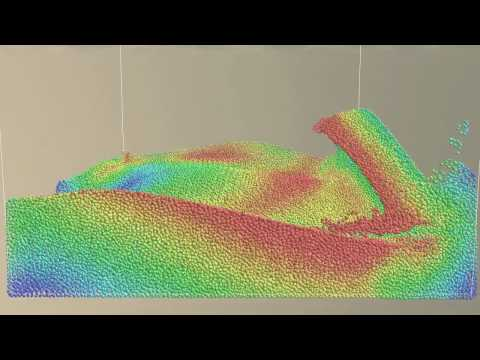

In [7]:
from IPython.display import YouTubeVideo

YouTubeVideo('6bdIHFTfTdU')

## A sidenote on SPH

The **density** is represented as a **kernel sum**:

[Smoothed Particle Hydrodynamics: Things I wish my mother
taught me](http://arxiv.org/pdf/1111.1259.pdf)



$$\rho(r) = \sum_{j=1}^{N_{neigb}} m_j W( |r - r_j|, h).$$

The simlest smoothing kernel is a 3D Gaussian, $W(x, h) = e^{-\frac{x^2}{h^2}}$.

## Modelling particles

In classical mechanics, to model the motion of particles, we need to defined the **Lagrangian**:

$$L_{sph} = \sum_{j} m_j \left(\frac{1}{2}v^2_j - u_j(\rho_j, s_j)\right).$$ 

$u_j$ is the internal energy, function of density and entropy.

## Using Euler-Lagrange

$$d[\frac{\partial L}{\partial v}]/dt = \frac{\partial L}{\partial r},$$

and the first law of thermodynamics, we get the following system of ordinary differential equations (ODEs).

$$\frac{dv_i}{dt} = -\sum_j \left(\frac{P_i}{\rho^2_i} + \frac{P_j}{\rho^2_j}\right) \nabla W(|r_i - r_j|, h),$$

which is a discrete form of the Euler equation 

$$
   \frac{dv}{dt} = -\frac{\nabla P}{\rho}.
$$

**Introducing dissipation is non-trivial** (one of the ways through Brownian motion).

## SPH and N-body

The evaluation of the right-hand side of the equation (for Euler or Runge-Kutta schemes) prequires N-body summation.

$$\frac{dv_i}{dt} = -\sum_j \left(\frac{P_i}{\rho^2_i} + \frac{P_j}{\rho^2_j}\right) \nabla W(|r_i - r_j|, h),$$


## Applications
Where the N-body problem arises in different problems with **long-range** interactions`
- Cosmology (interacting masses)
- Electrostatics (interacting charges)
- Molecular dynamics (more complicated interactions, maybe even 3-4 body terms).
- Particle modelling (**smoothed particle hydrodynamics**)
- Integral equations (**indirectly** after quadratures, the phylosophy is the same)

## Fast computation
$$
   V_i = \sum_{j} \frac{q_j}{\Vert x_i - y_j \Vert}
$$

Direct computation takes $\mathcal{O}(N^2)$ operations.

How to compute it fast?

The core idea: Barnes, Hut (Nature, 1986) 

Use clustering of particles!


## Idea on one slide
The idea was simple:
If a charge is far from a cluster of sources, it they are seen as one big "particle". 

<img src="earth-andromeda.jpeg" width = 70%>

## Barnes-Hut

Mathematically, the idea is as follows. Given a cluster of particles $K$ we approximate its **far field** (i.e. for all points outside a sphere of radius $r > r_K$ using the **total charge** and **center of mass**.

$$\sum_{j \in K} q_j F(x, y_j) \approx Q F(x, y_C)$$

$$Q = \sum_j q_j, \quad y_C = \frac{1}{J} \sum_{j} y_j$$

To compute the interaction, it is sufficient to replace by the a center-of-mass and a total mass!

What about the error of such approximation?

The points are not separated initially - what to do?

The idea of Barnes and Hut was to split the <font color='red'>  sources </font> into big blocks using the <font color='red'> cluster tree </font>


<img width=90% src='clustertree.png'>

## Cluster tree construction

The construction of a cluster tree is simple, and can be done by any clutering algorithm, i.e. **quadtree**, **kd-trees**, **inertial bisection**.

Generally, the particles are put into a **box**, and this box is split into several **children**.

If the box is small and/or contains **few particles**, it is not divided.

The complexity is $\mathcal{O}(N \log N)$ for a naive implementation.

##  Computing the interaction with a known tree

The algorithm is recursive.
Let $\mathcal{T}$ be the tree, and $x$ is the point where we need to
compute the potential.

- Set $N$ to the <font color='red'> root node </font>
- If $x$ and $N$ <font color='red'> are separated </font> , then  set $V(x) = Q V(y_{\mathrm{center}})$
- If $x$ and $N$ are not separated, compute $V(x) = \sum_{C \in
  \mathrm{sons}(N)} V(C, x)$ <font color='red'> recursion </font>

The complexity is $\mathcal{O}(\log N)$ for 1 point!


## Octtree
The simplest one: **quadtree/ octtree**, when you split the square into 4 squares and do that until the number of points is less that a parameter.  


It leads to the unbalanced tree, adding points is simple (but can unbalance it more).


## KD-tree
Another popular choice of the tree is the KD-tree

The construction is simple as well:  

Split along x-axis, then y-axis in such a way that the tree is **balanced** (i.e. the number of points in the left child/right child is similar).

The tree is always balanced, but biased towards the coordinate axis.

## Recursive inertial bisection

Compute the center-of-mass and select a hyperplane such that sum of squares of distances to it is minimal.

$$\sum_{j} \rho^2(x_j, \Pi) \rightarrow \min.$$

Often gives best complexity, but adding/removing points can be difficult.

## The scheme 
You can actually code it from this description!

- Construct the cluster tree
- Fill the tree with charges -- crucial  point, **upward pass**.
- For any point we now can compute the potential in $\mathcal{O}(\log N)$ flops (instead of $\mathcal{O}(N)$).


## Notes on the complexity

For each node of the tree, we need to compute its total mass and the center-of-mass. If we do it in a cycle, then the complexity will be $\mathcal{O}(N^2)$ for the tree constuction.  

However, it is easy to construct it in a smarter way.

- Start from the children (which contain only few particles) and fill then
- Bottom-to-top graph traversal: if we know the charges for the children, we can cheaply compute the total charge/center of massfor the father

Now you can actually code this (minor things remaining are the **bounding box** and separation criteria).

## Problems with Barnes-Hut
What are the problems with Barnes-Hut?

Well, several
- The logarithmic term 
- Low accuracy $\varepsilon = 10^{-2}$ is ok, but if we want $\varepsilon=10^{-5}$
  we have to take larger <font color='red'> separation criteria </font>  

## Solving problems with Barnes-Hut
- **Complexity**: To avoid the logarithmic term, we need to store two trees, for the sources, and for receivers
- **Accuracy**: instead of the <font color='red'> piecewise-constant approximation </font> which is inheritant in the BH algorithm, use more accurate representations.

Note that in the original scheme the sources and receivers are treated differently. In "Double Tree" they are treated in the same way.

## Double tree Barnes-Hut
Principal scheme of the Double-tree BH:

- Construct **two trees** for sources & receivers
- Fill the tree for sources with charges (bottom-to-top)
- Compute the interaction between **nodes** of the treess
- Fill the tree for receivers with potentials (top-to-bottom)


## Accuracy problem

The original BH method has low accuracy, and is in fact based on the expansion  

$$f(x, y) \approx f(x_0, y_0)$$

around the center-of-mass for $x, y$ sufficiently separated.

**What to do?**

**Answer:** Use higher-order expansions **Taylor expansions**!

$$f(x + \delta x, y + \delta y) \approx f(x, y) + \sum_{k, l=0}^p
(D^{k} D^{l} f)  \delta ^k
\delta y^l \frac{1}{k!} \frac{1}{l!} + \ldots
$$

## The multipole expansion

For the Coloumb interaction $\frac{1}{r}$ we have the **multipole expansion**

$$
     v(R) = \frac{Q}{R} + \frac{1}{R^3} \sum_{\alpha} P_{\alpha} R_{\alpha} + \frac{1}{6R^5} \sum_{\alpha, \beta} Q_{\alpha \beta} (3R_{\alpha \beta} - \delta_{\alpha \beta}R^2) + \ldots,
$$

where $P_{\alpha}$ is the **dipole moment**, $Q_{\alpha \beta}$ is the **quadrupole moment** (by actually, nothing more than the Taylor series expansion).

## Fast multipole method

This combination is very powerful, and 


<font color='red' size=6.0> Double tree + multipole expansion $\approx$ the Fast Multipole Method (FMM).  </font>

## FMM
We will talk about the exact implementation and the complexity issues in the next lecture.

## Problems with FMM

FMM has problems:
- It relies on analytic expansions; maybe difficult to obtain for the integral equations
- the higher is the order of the expansion, the larger is the complexity.
- That is why the **algebraic interpretation** (or kernel-independent FMM) is of great importance.

## FMM hardware

For cosmology this problem is so important, so that they have released a special hardware [Gravity Pipe](http://en.wikipedia.org/wiki/Gravity_Pipe) for solving the N-body problem

## FMM software
**Sidenote**, When you Google for "FMM", you will also encounter **fast marching method** (even in the scikit).

Everyone uses its own **in-house** software, so a good Python open-source software is yet to be written.  

This is also a perfect test for the **GPU** programming (can select as a term project as well).

## Overview of todays lecture

- The cluster tree
- Barnes-Hut and its problems
- Double tree / fast multipole method
- **Important difference**: element evaluation is **fast**. In integral equations, it is **slow**.

## Next lecture
- More detailed overview of the FMM algorithm, along with complexity estimates.
- Kernel-independent FMM.
- Algebraic interpretation of the FMM

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()